In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("../data/bike_buyers.csv")

In [3]:
data.head()

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000.0,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,42.0,No
1,24107,Married,Male,30000.0,3.0,Partial College,Clerical,Yes,1.0,0-1 Miles,Europe,43.0,No
2,14177,Married,Male,80000.0,5.0,Partial College,Professional,No,2.0,2-5 Miles,Europe,60.0,No
3,24381,Single,NaN,70000.0,0.0,Bachelors,Professional,Yes,1.0,5-10 Miles,Pacific,41.0,Yes
4,25597,Single,Male,30000.0,0.0,Bachelors,Clerical,No,0.0,0-1 Miles,Europe,36.0,Yes


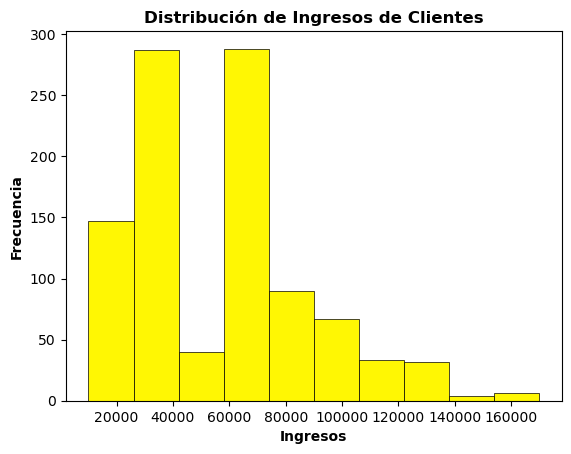

Promedio de los Ingresos: 56267.605633802814


In [4]:
plt.hist(data['Income'], bins = 10, edgecolor = 'black', linewidth = 0.5, color = '#FFF703')
plt.xlabel('Ingresos', weight = 'bold')
plt.ylabel('Frecuencia', weight = 'bold')
plt.title('Distribución de Ingresos de Clientes', weight = 'bold')
plt.show()

print("Promedio de los Ingresos:", data['Income'].mean())

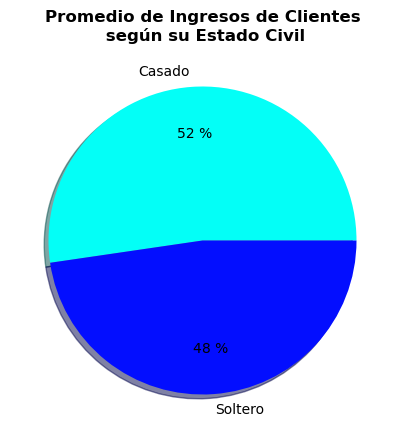

In [5]:
MS_prom = data.groupby(['Marital Status'])['Income'].mean()

plt.figure(figsize =(10, 5))
plt.pie(MS_prom, labels = ['Casado', 'Soltero'], autopct='%.0f %%', pctdistance = 0.7, shadow = True, colors = ['#03FFF7', '#030EFF'])
plt.title('Promedio de Ingresos de Clientes\n según su Estado Civil', weight = 'bold')
plt.show()

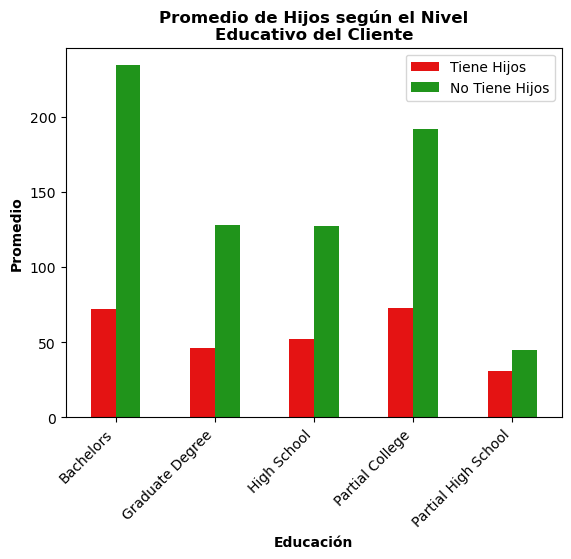

In [6]:
data['Con_hijos'] = np.where(data['Children'] != 0.0, 'Si', 'No')
Hijos_prom = data[['Education', 'Con_hijos']]
HP = Hijos_prom.groupby(['Education', 'Con_hijos']).size()
df = pd.DataFrame({'Frecuencia': HP.values}, index = HP.index)

df_pivot = df.pivot_table(index = 'Education', columns = 'Con_hijos', values = 'Frecuencia')
colores = ['#E41313', '#20941B']
ax = df_pivot.plot(kind = 'bar', stacked = False, color = colores)

ax.set_xlabel('Educación', weight = 'bold')
ax.set_ylabel('Promedio', weight = 'bold')
ax.set_title('Promedio de Hijos según el Nivel\nEducativo del Cliente', weight = 'bold')

ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right')
ax.legend(['Tiene Hijos', 'No Tiene Hijos'])

plt.show()

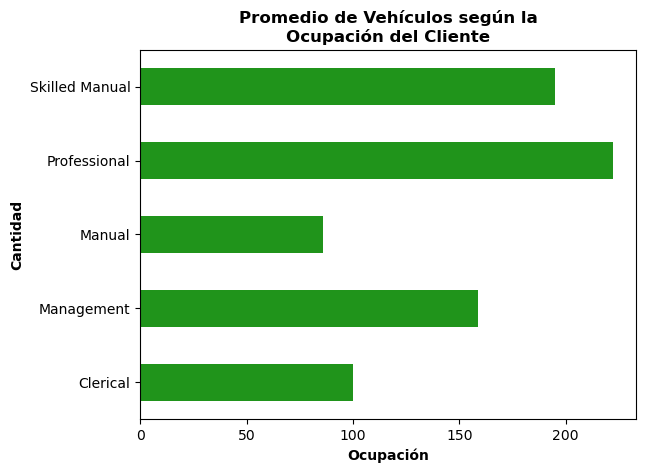

In [7]:
data['Con_vehiculo'] = np.where(data['Cars'] != 0.0, 'Si', 'No')
V_Si = data[data['Con_vehiculo'] == 'Si']
Vehiculo_prom = V_Si[['Occupation', 'Con_vehiculo']]
VP = Vehiculo_prom.groupby(['Occupation', 'Con_vehiculo']).size()
df = pd.DataFrame({'Frecuencia': VP.values}, index = VP.index)

df_pivot = df.pivot_table(index = 'Occupation', columns = 'Con_vehiculo', values = 'Frecuencia')
ax = df_pivot.plot(kind = 'barh', stacked = False, color = '#20941B')

ax.set_xlabel('Ocupación', weight = 'bold')
ax.set_ylabel('Cantidad', weight = 'bold')
ax.set_title('Promedio de Vehículos según la\nOcupación del Cliente', weight = 'bold')

ax.legend().set_visible(False)
plt.show()

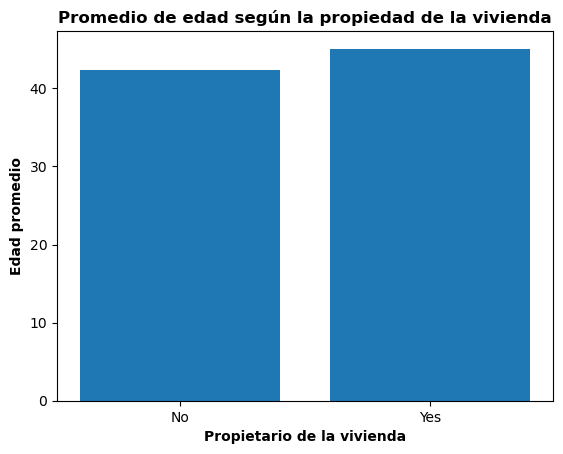

In [8]:
age_mean = data.groupby('Home Owner')['Age'].mean()

# Crear el gráfico de barras apiladas
plt.bar(age_mean.index, age_mean.values, label='Promedio de edad')
plt.xlabel('Propietario de la vivienda', weight = 'bold')
plt.ylabel('Edad promedio', weight = 'bold')
plt.title('Promedio de edad según la propiedad de la vivienda', weight = 'bold')
plt.legend().set_visible(False)
plt.show()